# 对PaperRecord实现聚类

### 环境准备

##### 常用环境导入

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

In [2]:
from sklearn.decomposition import PCA

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [16]:
import seaborn as sns

In [17]:
from sklearn.manifold import TSNE

##### 导入matplotlib

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

##### 连接数据库

In [14]:
import sqlite3

conn = sqlite3.connect("../db.sqlite3")

print("Open Database successfully")

Open Database successfully


In [19]:
cur = conn.cursor()
table_name = cur.execute("select name from sqlite_master where type='table' order by name").fetchall()
table_name

[('Training',),
 ('UserTemp',),
 ('account_confirmstring',),
 ('account_profile_awardhistory',),
 ('account_profile_awardhistory_User',),
 ('account_profile_competitionrecord',),
 ('account_profile_honortitle',),
 ('account_profile_paperrecord',),
 ('account_profile_patentrecord',),
 ('account_profile_publishrecord',),
 ('account_profile_researchproject',),
 ('account_user',),
 ('account_user_groups',),
 ('account_user_user_permissions',),
 ('auth_group',),
 ('auth_group_permissions',),
 ('auth_permission',),
 ('award_info_awardclassification',),
 ('award_info_awardinfo',),
 ('award_info_awardinfo_Major',),
 ('award_info_awardinfopost',),
 ('award_info_category',),
 ('award_info_post',),
 ('award_info_post_tags',),
 ('award_info_post_users_focus',),
 ('award_info_tag',),
 ('captcha_captchastore',),
 ('django_admin_log',),
 ('django_content_type',),
 ('django_migrations',),
 ('django_session',),
 ('grade_info_deptinfo',),
 ('grade_info_gradeinfo',),
 ('grade_info_lessoninfo',),
 ('grade

In [21]:
cur.execute("PRAGMA table_info(account_profile_paperrecord)")
cur.fetchall()

[(0, 'id', 'integer', 1, None, 1),
 (1, 'publishDate', 'date', 1, None, 0),
 (2, 'name', 'varchar(256)', 1, None, 0),
 (3, 'abstract', 'text', 0, None, 0),
 (4, 'magzineName', 'varchar(256)', 0, None, 0),
 (5, 'authOrder', 'varchar(1)', 1, None, 0),
 (6, 'totalAuthor', 'integer', 1, None, 0),
 (7, 'postStatus', 'varchar(2)', 1, None, 0),
 (8, 'totalReference', 'decimal', 1, None, 0),
 (9, 'conferenceChoice', 'varchar(2)', 1, None, 0),
 (10, 'SchoolYear_id', 'integer', 1, None, 0),
 (11, 'User_id', 'integer', 1, None, 0)]

### 构建CSV

In [22]:
csv_head = ["id", "User_id", "authOrder", "conferenceChoice"]

In [45]:
paper_record = conn.execute(("select {} from account_profile_paperrecord").
                            format(",".join(csv_head))).fetchall()

In [47]:
paper_record

[(532, 3889, 'f', 'ic'),
 (533, 3889, 'f', 'tm'),
 (534, 3889, 'f', 'ic'),
 (535, 3900, 'f', 'ic'),
 (536, 3102, 't', 'ic'),
 (537, 3163, 'f', 'im'),
 (538, 3163, 'f', 'im'),
 (539, 3897, 'f', 'tm'),
 (540, 4323, 'f', 'nc'),
 (541, 3037, 'f', 'ic'),
 (542, 3037, 'f', 'ic'),
 (543, 3587, 'f', 'ic'),
 (544, 3877, 'f', 'ic'),
 (545, 3893, 'f', 'ic'),
 (546, 3836, 'f', 'ic'),
 (547, 3925, 's', 'tm'),
 (548, 4021, 'f', 'im'),
 (549, 3922, 'f', 'ic'),
 (550, 3840, 's', 'nc'),
 (551, 3839, 's', 'ic'),
 (552, 3936, 's', 'nm'),
 (553, 3936, 's', 'nc'),
 (554, 3005, 'f', 'tm'),
 (555, 3005, 'f', 'tm'),
 (556, 3858, 'f', 'ic'),
 (557, 3858, 's', 'os'),
 (558, 3927, 's', 'tm'),
 (559, 3885, 'f', 'ic'),
 (560, 3917, 'f', 'ic'),
 (561, 3834, 'f', 'ic'),
 (562, 3895, 'f', 'ic'),
 (563, 3866, 's', 'nc'),
 (564, 3198, 's', 'im'),
 (565, 3198, 'f', 'nm'),
 (566, 3933, 'f', 'ic'),
 (567, 3948, 's', 'tm'),
 (568, 3948, 's', 'ic'),
 (569, 3174, 'f', 'ic'),
 (570, 4201, 'f', 'ic'),
 (571, 3874, 'f', 'ic'),


In [48]:
import csv
with open("paper_record.csv", "w", newline="") as f:
    ff = csv.writer(f)
    ff.writerow(csv_head)
    ff.writerows(paper_record)

### 读取CSV

In [56]:
df_paper = pd.read_csv("paper_record.csv", header=0, encoding="utf-8")
df_paper_regression_one_hot = df_paper.loc[:, [False, False, True, True]].copy()
df_paper_regression_fact = df_paper_regression_one_hot.copy()

### 确定Mapping

##### 使用自定义mapping(factorize)

In [57]:
conference_mapping = {
    'ic': 1,
    'im': 2,
    'nc': 3,
    'nm': 4,
    'os': 5,
    'tm': 6
}

auth_mapping = {
    'f': 1,
    'r': 2,
    's': 3,
    't': 4,
}

# df_paper_regression['authOrder'] = pd.factorize(df_paper_regression['authOrder'])
# df_paper_regression['conferenceChoice'] = pd.factorize(df_paper_regression['conferenceChoice'])

df_paper_regression_fact['authOrder'] = df_paper_regression_fact['authOrder'].map(auth_mapping)
df_paper_regression_fact['conferenceChoice'] = df_paper_regression_fact['conferenceChoice'].map(conference_mapping)

##### 使用one-hot encoding

In [58]:
df_paper_regression_one_hot = pd.get_dummies(df_paper_regression_one_hot)

##### TSNE/PCA可视化

#### TSNE可视化

one-hot 可视化

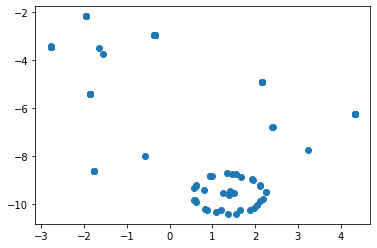

In [59]:
projection = TSNE().fit_transform(df_paper_regression_one_hot)
plt.scatter(*projection.T)

factorize可视化

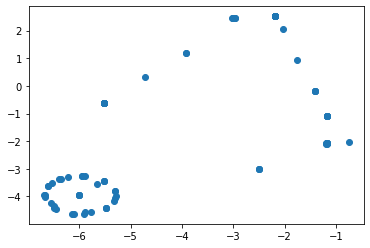

In [60]:
projection = TSNE().fit_transform(df_paper_regression_fact)
plt.scatter(*projection.T)

##### PCA可视化

one-hot可视化

pca = PCA(n_components=2)
projected = pca.fit_transform(df_paper_regression_one_hot)

#画出每个点的前两个主成份
plt.scatter(projected[:, 0], projected[:, 1], c=digits.target, edgecolor='none',
            alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

Text(0, 0.5, 'cumulative explained variance')

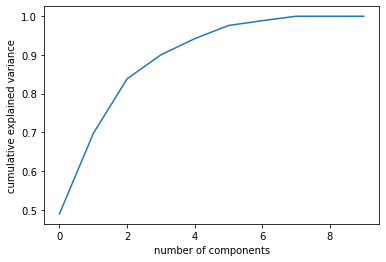

In [61]:
pca = PCA().fit(df_paper_regression_one_hot)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

fact可视化

Text(0, 0.5, 'cumulative explained variance')

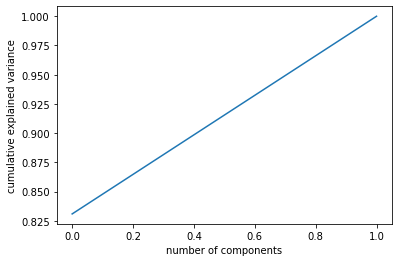

In [62]:
pca = PCA().fit(df_paper_regression_fact)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Kmeans

##### 聚类结果评价

In [13]:
# 定义between_SS / total_SS 的计算方法
def sum_of_square_scores(original_data, predict_labels, cluster_centers, n_clusters):
    avg = np.mean(original_data, axis=0)
    dist = np.power(original_data - avg, 2)
    total_ss = np.sum(dist)
    within_squares = np.zeros((n_clusters, len(original_data[0])))
    for i in range(0, len(original_data)):
        cluster = predict_labels[i]
        within_squares[cluster] += np.power(original_data[i] - cluster_centers[cluster], 2)
    within_ss = np.sum(within_squares)
    return (total_ss - within_ss) / total_ss

##### one-hot 输出

In [23]:
kmeans_one_hot = KMeans(n_clusters=5, random_state=10).fit(df_paper_regression_one_hot)

In [24]:
kmeans_one_hot.labels_

array([2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 1, 2, 0, 4, 0, 0,
       1, 1, 2, 0, 3, 2, 2, 2, 2, 0, 0, 1, 2, 3, 4, 2, 2, 2, 2, 2, 2, 1,
       2, 3, 3, 3, 4, 1, 3, 3, 0, 2, 4, 2, 4, 1, 4, 2, 2, 1, 2, 2, 1, 2,
       3, 2, 0, 4, 1, 3, 1, 0, 0, 0, 2, 2, 2, 0, 3, 2, 4, 2, 2, 2, 2, 2],
      dtype=int32)

##### factorize输出

In [25]:
kmeans_factorize = KMeans(n_clusters=5, random_state=10).fit(df_paper_regression_fact)
kmeans_factorize.labels_

array([1, 4, 1, 1, 2, 1, 1, 4, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 2, 0, 0,
       4, 4, 1, 3, 3, 1, 1, 1, 1, 0, 2, 0, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 2, 1, 3, 3, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 2, 2, 4, 3, 0, 2, 2, 2, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1],
      dtype=int32)

可以看到one-hot的输出结果和factorize有所差异，归根结底是距离度量的问题

In [26]:
kmeans_factorize.cluster_centers_

array([[2.25      , 3.375     ],
       [1.0625    , 1.16666667],
       [3.06666667, 1.4       ],
       [3.        , 5.91666667],
       [1.        , 6.        ]])

#### Kmeans 多簇比较

##### one-hot

In [64]:
scores_one_hot_sil = []
scores_one_hot_cal = []

for i in range(2, 10):
    km = KMeans(n_clusters=i)
    km.fit(df_paper_regression_one_hot)
    scores_one_hot_sil.append(silhouette_score(df_paper_regression_one_hot, km.labels_))
    scores_one_hot_cal.append(calinski_harabasz_score(df_paper_regression_one_hot, km.labels_))


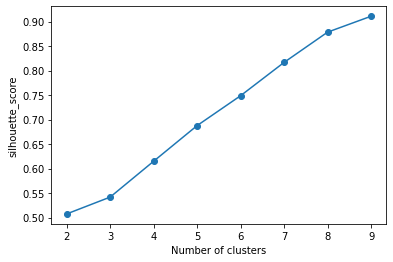

In [65]:
plt.plot(range(2,10), scores_one_hot_sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.savefig("Paper_kmeans_sc_one_h.png")
plt.show()

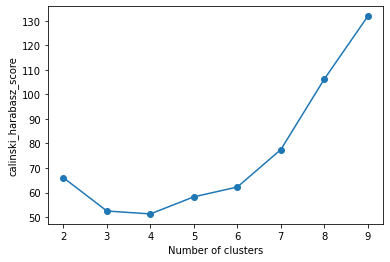

In [66]:
plt.plot(range(2,10), scores_one_hot_cal, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('calinski_harabasz_score')
plt.savefig("Paper_kmeans_cc_one_h.png")
plt.show()

##### factorize

In [67]:
scores_one_hot_sil = []
scores_one_hot_cal = []

for i in range(2, 10):
    km = KMeans(n_clusters=i)
    km.fit(df_paper_regression_fact)
    scores_one_hot_sil.append(silhouette_score(df_paper_regression_fact, km.labels_))
    scores_one_hot_cal.append(calinski_harabasz_score(df_paper_regression_fact, km.labels_))


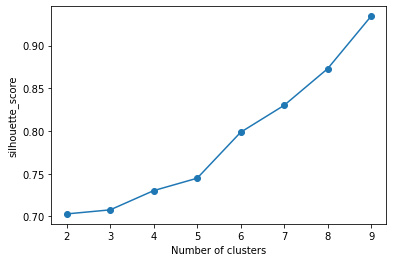

In [69]:
plt.plot(range(2,10), scores_one_hot_sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.savefig("Paper_kmeans_sc_fac.png")
plt.show()

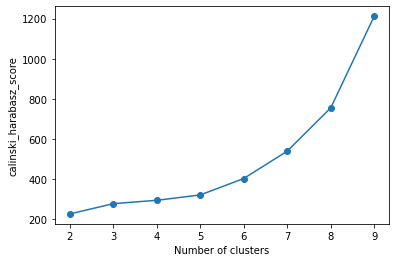

In [70]:
plt.plot(range(2,10), scores_one_hot_cal, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('calinski_harabasz_score')
plt.savefig("Paper_kmeans_cc_fac.png")
plt.show()

##### 保存聚类结果输出CSV

##### Factorize结果

In [54]:
sil_coeff = silhouette_score(df_paper_regression_fact, kmeans_factorize.labels_)
# bss = sum_of_square_scores(df_paper_regression_fact, kmeans_factorize.labels_, kmeans_factorize.cluster_centers_, kmeans_factorize.n_clusters)
print("coeff:" + str(sil_coeff))
cal_score = calinski_harabasz_score(df_paper_regression_fact, kmeans_factorize.labels_)
print("calinski score:" + str(cal_score))
# print("between_ss / total_ss:" + str(bss))

coeff:0.753975106803399
calinski score:324.93672755326276


In [27]:
df_paper_regression_fact['labels'] = kmeans_factorize.labels_

In [28]:
df_paper_regression_fact

,authOrder,conferenceChoice,labels
0,1,1,1
1,1,6,4
2,1,1,1
3,1,1,1
4,4,1,2
...,...,...,...
83,1,1,1
84,1,1,1
85,2,1,1
86,1,1,1


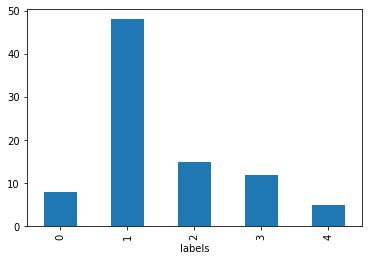

In [29]:
df_paper_regression_fact.groupby('labels')['labels'].count().plot(kind="bar")

In [32]:
df_paper_regression_fact.to_csv('paper_regression_fact.csv')

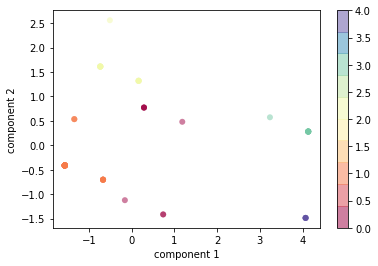

In [34]:
pca = PCA(n_components=2)
projected = pca.fit_transform(df_paper_regression_fact)
plt.scatter(projected[:, 0], projected[:, 1], c=df_paper_regression_fact['labels'], edgecolor='none',
            alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.savefig("PCA_new_kmeans_factorize.png")

##### one-hot结果

In [53]:
sil_coeff = silhouette_score(df_paper_regression_one_hot, kmeans_one_hot.labels_)
# bss = sum_of_square_scores(df_paper_regression_fact, kmeans_factorize.labels_, kmeans_factorize.cluster_centers_, kmeans_factorize.n_clusters)
print("coeff:" + str(sil_coeff))
cal_score = calinski_harabasz_score(df_paper_regression_one_hot, kmeans_one_hot.labels_)
print("calinski score:" + str(cal_score))
# print("between_ss / total_ss:" + str(bss))

coeff:0.7016505779312342
calinski score:62.469082369381255


In [35]:
df_paper_regression_one_hot['labels'] = kmeans_one_hot.labels_

In [36]:
df_paper_regression_one_hot

,authOrder_f,authOrder_r,authOrder_s,authOrder_t,conferenceChoice_ic,conferenceChoice_im,conferenceChoice_nc,conferenceChoice_nm,conferenceChoice_os,conferenceChoice_tm,labels
0,1,0,0,0,1,0,0,0,0,0,2
1,1,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,1,0,0,0,0,0,2
3,1,0,0,0,1,0,0,0,0,0,2
4,0,0,0,1,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
83,1,0,0,0,1,0,0,0,0,0,2
84,1,0,0,0,1,0,0,0,0,0,2
85,0,1,0,0,1,0,0,0,0,0,2
86,1,0,0,0,1,0,0,0,0,0,2


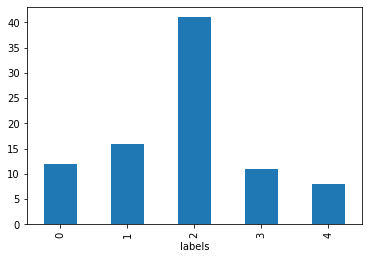

In [37]:
%matplotlib inline
df_paper_regression_one_hot.groupby('labels')['labels'].count().plot(kind='bar')

In [38]:
df_paper_regression_one_hot.to_csv("paper_regression_one_hot.csv")

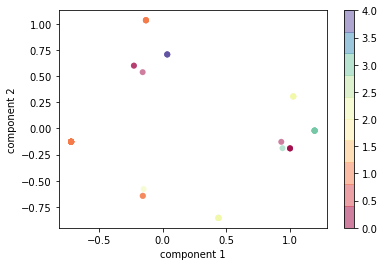

In [33]:
pca = PCA(n_components=2)
projected = pca.fit_transform(df_paper_regression_one_hot)
plt.scatter(projected[:, 0], projected[:, 1], c=df_paper_regression_fact['labels'], edgecolor='none',
            alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.savefig("PCA_new_kmeans_one_hot.png")

从上述明显看出factorize后聚类效果更好

接下来的可以尝试多种不同的聚类簇数

### HDBScan

##### one-hot encoding

In [9]:
import hdbscan

In [15]:
clusterer_one_hot = hdbscan.HDBSCAN(gen_min_span_tree=True, prediction_data=True)
clusterer_one_hot.fit(df_paper_regression_one_hot)
clusterer_one_hot.labels_

array([ 4, -1,  4,  4, -1,  5,  5, -1, -1,  4,  4,  4,  4,  4,  4,  2,  5,
        4,  0,  3,  0,  0, -1, -1,  4,  0,  2,  4,  4,  4,  4,  0,  1, -1,
        4,  2,  3,  4,  4,  4,  4,  4,  4,  5,  4,  2,  2,  2,  3,  5,  2,
        2,  0,  4,  3,  4,  3,  5,  3,  4, -1,  5,  4, -1,  5,  4,  2,  4,
        1,  3, -1,  2, -1,  1,  1,  1,  4,  4,  4,  1,  2,  4,  3,  4,  4,
       -1,  4,  4])

不知道下面的为什么有问题,而且很多聚类结果Prob为0或1

In [ ]:
clusterer_one_hot.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

/Users/cuichengyuan/anaconda3/lib/python3.7/site-packages/hdbscan/plots.py:817: RuntimeWarning: divide by zero encountered in true_divide
  line_width = edge_linewidth * (np.log(self._mst.T[2].max() / self._mst.T[2]) + 1.0)


In [11]:
clusterer_one_hot.probabilities_

array([1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1.])

##### factorize

In [14]:
clusterer_fact = hdbscan.HDBSCAN(gen_min_span_tree=True, prediction_data=True)
clusterer_fact.fit(df_paper_regression_fact)
clusterer_fact.labels_

array([ 2,  0,  2,  2,  4,  3,  3,  0, -1,  2,  2,  2,  2,  2,  2,  1,  3,
        2, -1,  4, -1, -1,  0,  0,  2, -1,  1,  2,  2,  2,  2, -1,  5,  0,
        2,  1,  4,  2,  2,  2,  2,  2,  2,  3,  2,  1,  1,  1,  4,  3,  1,
        1, -1,  2,  4,  2,  4,  3,  4,  2, -1,  3,  2, -1,  3,  2,  1,  2,
        5,  4,  0,  1,  0,  5,  5,  5,  2,  2,  2,  5,  1,  2,  4,  2,  2,
       -1,  2,  2])

In [13]:
clusterer_fact.probabilities_

array([1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1.])